<a id='top-page'></a>
# <img src="../images/PCAfold-logo.svg" style="height:100px"> Demo for performing PCA on sampled data sets

In this tutorial, we present how PCA can be performed on sampled data sets using
various helpful functions from the ``preprocess`` and the ``reduction`` module. Those functions essentially allow to compare PCA done on the original full data set, $\mathbf{X}$, and on the sampled data set, $\mathbf{X_r}$. We are first going to present major functionalities for performing and analyzing PCA on a sampled data set using a special case of sampling - by taking equal number of samples from each cluster. Next, we are going to show a more general way to
perform PCA on data sets that are sampled in any way of choice. A general overview for performing PCA on a sampled data set is presented below:

<img src="../images/pca-on-sampled-data-set.svg" style="height:200px">

The main goal is to inform the PCA transformation with some of the characteristics of the sampled data set, $\mathbf{X_r}$. There are several ways in which that information
can be incorporated and they can be controlled using a selected *biasing option* and setting the ``biasing_option`` input parameter whenever needed. The user is referred to the documentation for more information on the available options (under **User guide** $\rightarrow$ **Data reduction** $\rightarrow$ **Biasing options**). It is understood, that PCA performed on a sampled data set is *biased* in some way, since that data set contains different
proportions of features in terms of sample density compared to their original
contribution within the full original data set, $\mathbf{X}$. Those features can be identified using any clustering technique of choice.



### PCA on sampled data sets

- [**Load and cluster the data set**](#load-data)
- [**Special case of PCA on sampled data sets**](#special-case)
    - [**Run cluster equilibration**](#run_cluster_equilibration)
    - [**Analyze centers change**](#centers_change)
    - [**Analyze eigenvector weights change**](#eigenvector_weights_movement)
    - [**Analyze eigenvalue distribution**](#eigenvalue_distribution)
    - [**Visualize the re-sampled manifold**](#biased_manifold)
- [**Generalization of PCA on sampled data sets**](#generalized_sampling)
- [**References**](#references)

***

**Should plots be saved?**

In [1]:
save_plots = False

***

We import the necessary modules:

In [2]:
from PCAfold import preprocess
from PCAfold import reduction
from PCAfold import DataSampler
from PCAfold import PCA
import numpy as np
from matplotlib.colors import ListedColormap
%matplotlib inline

and we set some initial parameters:

In [3]:
scaling = 'auto'
biasing_option = 2
n_clusters = 4
n_components = 2
random_seed = 100
legend_label = ['$\mathbf{X}$', '$\mathbf{X_r}$']
color_map = ListedColormap(['#0e7da7', '#ceca70', '#b45050', '#2d2d54'])
save_filename = None

<a id='load-data'></a>
***

## Load and cluster the data set

[**↑ Go to the top**](#top-page)

As an example, we will use a data set representing combustion of syngas in air generated from the steady laminar flamelet model using chemical mechanism by Hawkes et al. [[1]](#references).
This data set has 11 variables and 50,000 observations. The data set was generated
using [*Spitfire*](https://github.com/sandialabs/Spitfire) software [[2]](#references). To load the data set
from the tutorials directory:

In [4]:
X = np.genfromtxt('data-state-space.csv', delimiter=',')
X_names = ['$T$', '$H_2$', '$O_2$', '$O$', '$OH$', '$H_2O$', '$H$', '$HO_2$', '$CO$', '$CO_2$', '$HCO$']
S_X = np.genfromtxt('data-state-space-sources.csv', delimiter=',')
Z = np.genfromtxt('data-mixture-fraction.csv', delimiter=',')

We start with clustering the data set that will result in an `idx` vector of cluser classifications. Clustering can be performed with any technique of choice. Here we will use one of the available functions from the `preprocess` module `preprocess.zero_neighborhood_bins` and use the first principal component source term as the conditioning variable.

Perform global PCA on the data set and transform source terms of the original variables:

In [5]:
pca_X = PCA(X, scaling=scaling, n_components=n_components)
S_Z = pca_X.transform(S_X, nocenter=True)

Cluster the data set:

In [6]:
(idx, borders) = preprocess.zero_neighborhood_bins(S_Z[:,0], k=4, zero_offset_percentage=2, split_at_zero=True, verbose=True)

Border values for bins:
[-87229.83051401  -2287.56587856      0.           2287.56587856
  27148.46341416]

Bounds for cluster 0:
	-87229.8305, -2288.0867
Bounds for cluster 1:
	-2286.3687, -0.0
Bounds for cluster 2:
	0.0, 2286.6953
Bounds for cluster 3:
	2288.3, 27148.4634


Visualize the result of clustering:

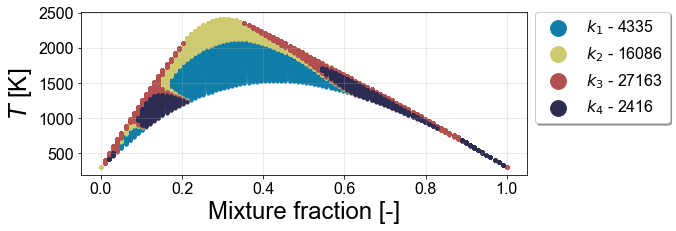

In [7]:
if save_plots == True: save_filename = '../images/tutorial-sampled-pca-clustering.svg'
plt = preprocess.plot_2d_clustering(Z, X[:,0], idx, x_label='Mixture fraction [-]', y_label='$T$ [K]', color_map=color_map, first_cluster_index_zero=False, grid_on=True, figure_size=(8, 3), save_filename=save_filename)

<a id='special-case'></a>
***

## Special case of PCA on sampled data sets   

[**↑ Go to the top**](#top-page)

In this section, we present the special case for performing PCA on data sets formed by taking equal number of samples from local clusters.

The ``reduction.EquilibratedSamplePCA`` class enables a special case of performing PCA on a sampled data set. It uses equal number of samples from each cluster and allows to
analyze what happens when the data set is sampled gradually. It begins with
performing PCA on the original data set and then in
``n_iterations`` it will gradually decrease the number of populations in each
cluster larger than the smallest cluster, heading towards population of the
smallest cluster, in each cluster. At each iteration, we obtain a new sampled data set on which PCA is performed.
At the last iteration, the number of populations in each cluster are equal and,
finally, PCA is performed on this *equilibrated* data set.

A schematic representation of this procedure is presented in the figure below:

<img src="../images/cluster-equilibration-scheme.svg" style="height:300px">

<a id='run_cluster_equilibration'></a>
### Run cluster equilibration

[**↑ Go to the top**](#top-page)

With ``verbose=True`` we will see some detailed information on thee number of samples
in each cluster at each iteration:

In [8]:
equilibrated_pca = reduction.EquilibratedSamplePCA(X, 
                                                   idx, 
                                                   scaling=scaling, 
                                                   X_source=S_X, 
                                                   n_components=n_components, 
                                                   biasing_option=biasing_option, 
                                                   n_iterations=10, 
                                                   stop_iter=0, 
                                                   random_seed=random_seed, 
                                                   verbose=True)

Biasing is performed with option 2.

At iteration 1 taking samples:
{0: 4144, 1: 14719, 2: 24689, 3: 2416}

At iteration 2 taking samples:
{0: 3953, 1: 13352, 2: 22215, 3: 2416}

At iteration 3 taking samples:
{0: 3762, 1: 11985, 2: 19741, 3: 2416}

At iteration 4 taking samples:
{0: 3571, 1: 10618, 2: 17267, 3: 2416}

At iteration 5 taking samples:
{0: 3380, 1: 9251, 2: 14793, 3: 2416}

At iteration 6 taking samples:
{0: 3189, 1: 7884, 2: 12319, 3: 2416}

At iteration 7 taking samples:
{0: 2998, 1: 6517, 2: 9845, 3: 2416}

At iteration 8 taking samples:
{0: 2807, 1: 5150, 2: 7371, 3: 2416}

At iteration 9 taking samples:
{0: 2616, 1: 3783, 2: 4897, 3: 2416}

At iteration 10 taking samples:
{0: 2416, 1: 2416, 2: 2416, 3: 2416}


In [9]:
eigenvalues = equilibrated_pca.eigenvalues
eigenvectors = equilibrated_pca.eigenvectors
PCs = equilibrated_pca.pc_scores
PC_sources = equilibrated_pca.pc_sources
idx_train = equilibrated_pca.idx_train

<a id='centers_change'></a>
### Analyze centers change

[**↑ Go to the top**](#top-page)

The ``reduction.analyze_centers_change`` function compares centers computed on the original data set, $\mathbf{X}$, versus on the sampled data set, $\mathbf{X_r}$.
The ``idx_train`` input parameter could for instance be obtained
from ``reduction.EquilibratedSamplePCA``
and will thus represent the equilibrated data set sampled from the original data
set. It could also be obtained as sampled indices using any of the sampling
function from the ``preprocess.DataSampler`` class.

This function will produce a plot that shows the normalized centers and a
percentage by which the new centers have moved with respect to the original
ones. Example of a plot:

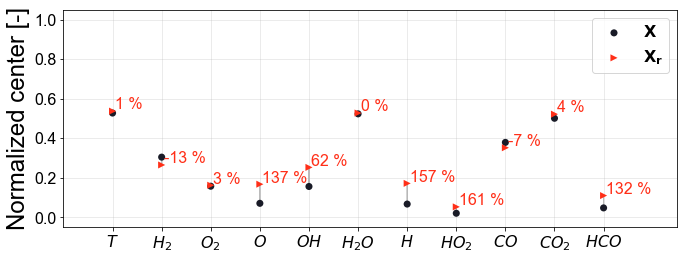

In [10]:
if save_plots: save_filename = '../images/centers-change.svg'
(centers_X, centers_X_r, perc, plt) = reduction.analyze_centers_change(X, idx_train, variable_names=X_names, legend_label=legend_label, save_filename=save_filename)

If you do not wish to plot all variables present in a data set, use the
``plot_variables`` list as an input parameter to select indices of variables to
plot:

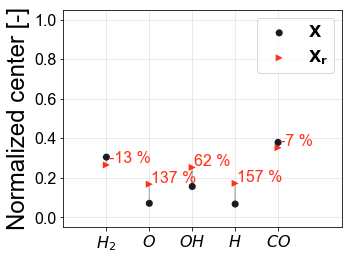

In [11]:
if save_plots: save_filename = '../images/centers-change-selected-variables.svg'
(centers_X, centers_X_r, perc, plt) = reduction.analyze_centers_change(X, idx_train, variable_names=X_names, plot_variables=[1,3,4,6,8], legend_label=legend_label, save_filename=save_filename)

<a id='eigenvector_weights_movement'></a>
### Analyze eigenvector weights change

[**↑ Go to the top**](#top-page)

The ``eigenvectors`` 3D array obtained from ``reduction.EquilibratedSamplePCA``
can now be used as an input parameter for plotting the eigenvector weights change
as we were gradually equilibrating cluster populations.

We are going to plot the first eigenvector (corresponding to PC-1) weights movement with three variants of normalization. To access the first eigenvector one can simply do:

```python
eigenvectors[:,0,:]
```

similarly, to access the second eigenvector:

```python
eigenvectors[:,1,:]
```

and so on.

Three weight normalization variants are available:

- No normalization, the absolute values of the eigenvector weights are plotted. To use this variant set ``normalize=False``. Example can be seen below:

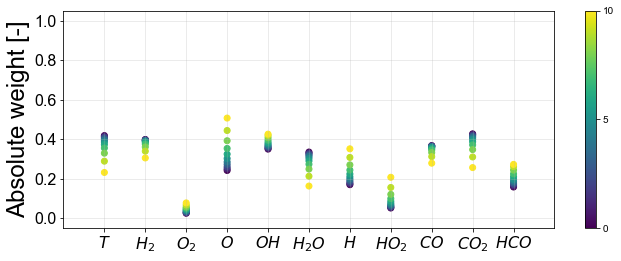

In [12]:
if save_plots: save_filename = '../images/eigenvector-weights-movement-non-normalized.svg'
plt = reduction.analyze_eigenvector_weights_change(eigenvectors[:,0,:], X_names, plot_variables=[], normalize=False, zero_norm=False, save_filename=save_filename)

- Normalizing so that the highest weight is equal to 1 and the smallest weight
  is between 0 and 1. This is useful for judging the severity of the weight change.
  To use this variant set ``normalize=True`` and ``zero_norm=False``.
  Example can be seen below:

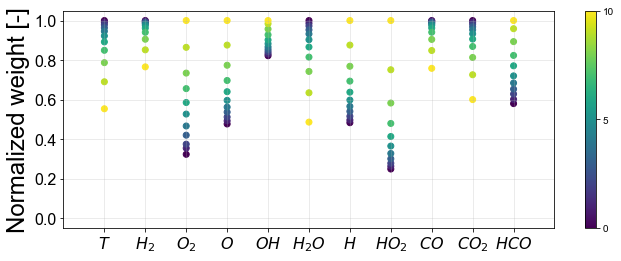

In [13]:
if save_plots: save_filename = '../images/eigenvector-weights-movement-normalized.svg'
plt = reduction.analyze_eigenvector_weights_change(eigenvectors[:,0,:], X_names, plot_variables=[], normalize=True, zero_norm=False, save_filename=save_filename)

- Normalizing so that weights are between 0 and 1. This is useful for judging
  the change trends since it will blow up even the smallest changes to the entire
  range 0-1. To use this variant set ``normalize=True`` and ``zero_norm=True``.
  Example can be seen below:

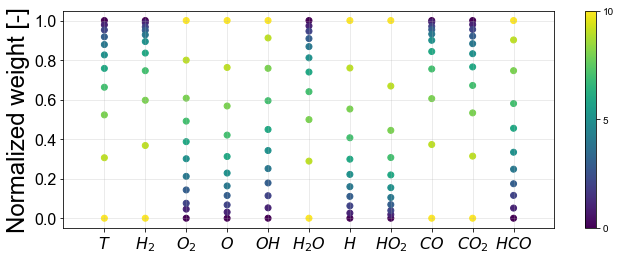

In [14]:
if save_plots: save_filename = '../images/eigenvector-weights-movement-normalized-to-zero.svg'
plt = reduction.analyze_eigenvector_weights_change(eigenvectors[:,0,:], X_names, plot_variables=[], normalize=True, zero_norm=True, save_filename=save_filename)

Note, that in the above example, the color bar marks the iteration number and so the $0^{th}$ iteration represents eigenvectors from the original data set, $\mathbf{X}$. The last iteration, in this example the $10^{th}$ iteration, represents eigenvectors computed on the *equilibrated*, sampled data set.

If you do not wish to plot all variables present in a data set, use the
``plot_variables`` list as an input parameter to select indices of variables to
plot:

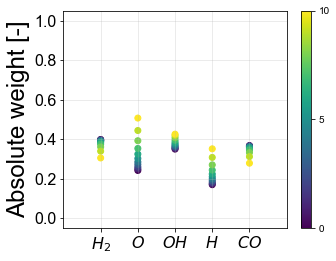

In [15]:
if save_plots: save_filename = '../images/eigenvector-weights-movement-selected-variables.svg'
plt = reduction.analyze_eigenvector_weights_change(eigenvectors[:,0,:], X_names, plot_variables=[1,3,4,6,8], normalize=False, zero_norm=False, save_filename=save_filename)

If you are only interested in plotting the comparison in the eigenvector weights change between the original data set, $\mathbf{X}$, and one target sampled data set, $\mathbf{X_r}$, (for instance the *equilibrated* data set) you can set the eigenvectors input parameter to only contain these two sets of weights. The function will then understand that only these two should be compared:

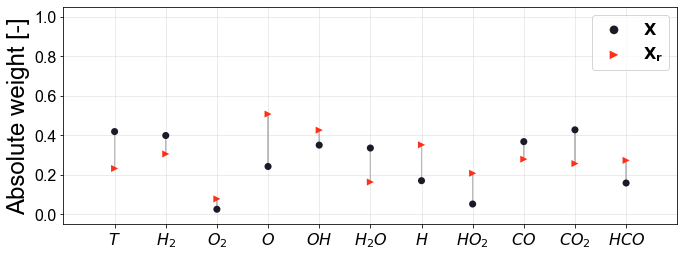

In [16]:
if save_plots: save_filename = '../images/eigenvector-weights-movement-X-Xr.svg'
plt = reduction.analyze_eigenvector_weights_change(eigenvectors[:,0,[0,-1]], X_names, normalize=False, zero_norm=False, legend_label=legend_label, save_filename=save_filename)

Such plot can be done for the pre-selected variables as well using the
``plot_variables`` list:

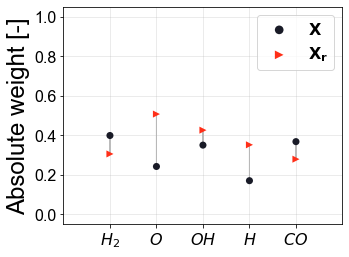

In [17]:
if save_plots: save_filename = '../images/eigenvector-weights-movement-X-Xr-selected-variables.svg'
plt = reduction.analyze_eigenvector_weights_change(eigenvectors[:,0,[0,-1]], X_names, plot_variables=[1,3,4,6,8], normalize=False, zero_norm=False, legend_label=legend_label, save_filename=save_filename)

<a id='eigenvalue_distribution'></a>
### Analyze eigenvalue distribution

[**↑ Go to the top**](#top-page)

The ``reduction.analyze_eigenvalue_distribution`` function will produce a plot that shows the normalized eigenvalues distribution for the original data set, $\mathbf{X}$, and for the sampled data set, $\mathbf{X_r}$. Example of a plot:

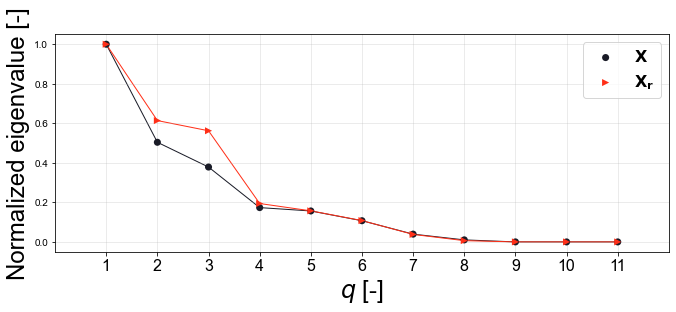

In [18]:
if save_plots: save_filename = '../images/eigenvalue-distribution.svg'
plt = reduction.analyze_eigenvalue_distribution(X, idx_train, scaling, biasing_option, legend_label=legend_label, save_filename=save_filename)

<a id='biased_manifold'></a>
### Visualize the re-sampled manifold

[**↑ Go to the top**](#top-page)

Using the function ``reduction.plot_2d_manifold`` you can visualize any
two-dimensional manifold and additionally color it with a variable of choice.
Here we are going to plot the re-sampled manifold resulting from performing PCA on
the sampled data set. Example of a plot:

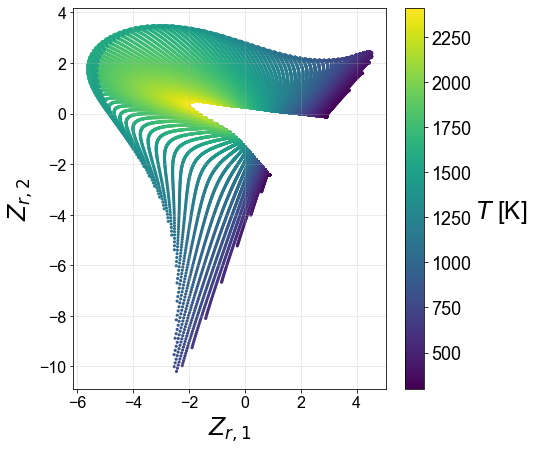

In [19]:
if save_plots: save_filename = '../images/re-sampled-manifold.svg'
plt = reduction.plot_2d_manifold(PCs[:,0,-1], PCs[:,1,-1], color=X[:,0], x_label='$Z_{r, 1}$', y_label='$Z_{r, 2}$', colorbar_label='$T$ [K]', save_filename=save_filename)

***
<a id='generalized_sampling'></a>
## Generalization of PCA on sampled data sets

[**↑ Go to the top**](#top-page)

A more general approach to performing PCA on sampled data sets (instead of using the
``reduction.EquilibratedSamplePCA`` class) is to use the
the ``reduction.SamplePCA`` class. This function allows to perform PCA on
a data set that has been sampled in any way (in contrast to *equilibrated* sampling
which always samples equal number of samples from each cluster).

> It is worth noting that the class ``reduction.EquilibratedSamplePCA`` uses ``reduction.SamplePCA`` inside.

We first inspect how many samples each cluster has (in the clusters we
identified earlier by binning the first principal component source term):

In [20]:
print(preprocess.get_populations(idx))

[4335, 16086, 27163, 2416]


We begin by performing manual sampling. Suppose that we would like to severly under-represent the two largest clusters and over-represent the features of the two smallest clusters. Let's select 4000 samples from $k_0$, 1000 samples from $k_1$, 1000 samples from $k_2$ and 2400 samples from $k_3$. In this example we are not interested in generating test samples, so we can suppress returning those.

In [21]:
sample = DataSampler(idx, idx_test=None, random_seed=random_seed, verbose=True)
(idx_manual, _) = sample.manual({0:4000, 1:1000, 2:1000, 3:2400}, sampling_type='number', test_selection_option=1)

Cluster 0: taking 4000 train samples out of 4335 observations (92.3%).
Cluster 1: taking 1000 train samples out of 16086 observations (6.2%).
Cluster 2: taking 1000 train samples out of 27163 observations (3.7%).
Cluster 3: taking 2400 train samples out of 2416 observations (99.3%).

Cluster 0: taking 335 test samples out of 335 remaining observations (100.0%).
Cluster 1: taking 15086 test samples out of 15086 remaining observations (100.0%).
Cluster 2: taking 26163 test samples out of 26163 remaining observations (100.0%).
Cluster 3: taking 16 test samples out of 16 remaining observations (100.0%).

Selected 8400 train samples (16.8%) and 41600 test samples (83.2%).



We now perform PCA on a data set that has been sampled according to
``idx_manual`` using the ``reduction.SamplePCA`` class:

In [22]:
sample_pca = reduction.SamplePCA(X, 
                                 idx_manual, 
                                 scaling, 
                                 n_components, 
                                 biasing_option)

In [23]:
eigenvalues_manual = sample_pca.eigenvalues
eigenvectors_manual = sample_pca.eigenvectors
PCs_manual = sample_pca.pc_scores

Finally, we can generate all the same plots that were shown before.
Here, we are only going to present the new re-sampled manifold resulting from
current manual sampling:

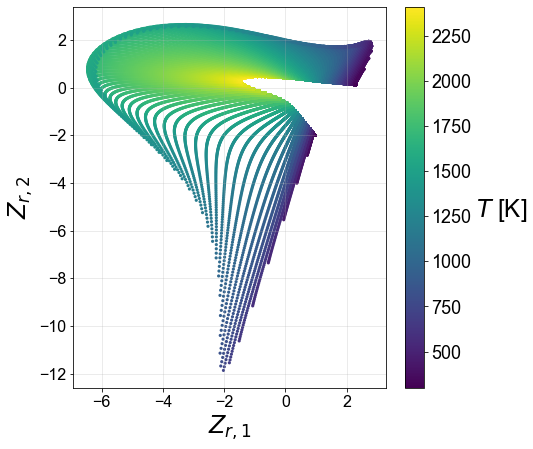

In [24]:
if save_plots: save_filename = '../images/generalize-sampling-re-sampled-manifold.svg'
plt = reduction.plot_2d_manifold(PCs_manual[:,0], PCs_manual[:,1], color=X[:,0], x_label='$Z_{r, 1}$', y_label='$Z_{r, 2}$', colorbar_label='$T$ [K]', save_filename=save_filename)

<a id='references'></a>
***

## References

[**↑ Go to the top**](#top-page)

> [[1]](#load-data) E. R. Hawkes, R. Sankaran, J. C. Sutherland, J. H. Chen, *Scalar mixing in direct numerical simulations of temporally evolving plane jet flames with skeletal co/h2 kinetics*, Proceedings of the combustion institute 31 (1) (2007) 1633–1640
> 
> [[2]](#load-data) [M. A. Hansen, *Spitfire*, 2020](https://github.com/sandialabs/Spitfire)

***